In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = 15, 6
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%run period.py 64 2 0.25 --model_type gru --sigma 1e-9 --sim_type period/uneven/noise0 --uneven --no_train
pred_gru = model.predict(X[test])
np.mean((pred_gru[:, 0:1] - Y[test, 0:1]) ** 2)

Using TensorFlow backend.


[]
/Users/brettnaul/Dropbox/Documents/timeflow/keras_logs/period/uneven/noise0/gru_064_x2_2m03_drop25
Loading /Users/brettnaul/Dropbox/Documents/timeflow/keras_logs/period/uneven/noise0/gru_064_x2_2m03_drop25/weights.h5...


0.030460842010406299

In [ ]:
#%run period.py 64 2 0.25 --model_type gru --sigma 1 --sim_type period_only/even/noise1 --even
#pred_gru = model.predict(X[test])
#np.mean((pred_gru[:, 0:1] - Y[test, 0:1]) ** 2)

In [5]:
%%time
from gatspy.periodic import LombScargle, LombScargleFast

pred_gat = np.zeros(pred_gru.shape)
for i in range(100):#args.N_test):
#    opt_args = {'period_range': (0.1, 0.9 * (X[test[i]][-1, 0] - X[test[i]][0, 0])), 'quiet': True}
    opt_args = {'period_range': (0.5, 2 * 0.99 * np.pi), 'quiet': True}
    model_gat = LombScargle(fit_period=True, optimizer_kwds=opt_args)#, silence_warnings=True)
    model_gat.fit(np.linspace(0, 2 * np.pi, args.n_max), X[test[i]][:, 0])
    omega = 2 * np.pi / model_gat.best_period
    off, A1, A2 = model_gat._best_params(omega)
#    pred_gat[i] = np.array([omega / 2 / np.pi, np.sqrt(A1 ** 2 + A2 ** 2), np.arctan2(A2, A1), off + model_gat.ymean_])
    pred_gat[i] = np.array([model_gat.best_period, np.sqrt(A1 ** 2 + A2 ** 2), np.arctan2(A2, A1), off + model_gat.ymean_])

CPU times: user 7.48 s, sys: 20.7 ms, total: 7.5 s
Wall time: 7.52 s


In [6]:
i = -1

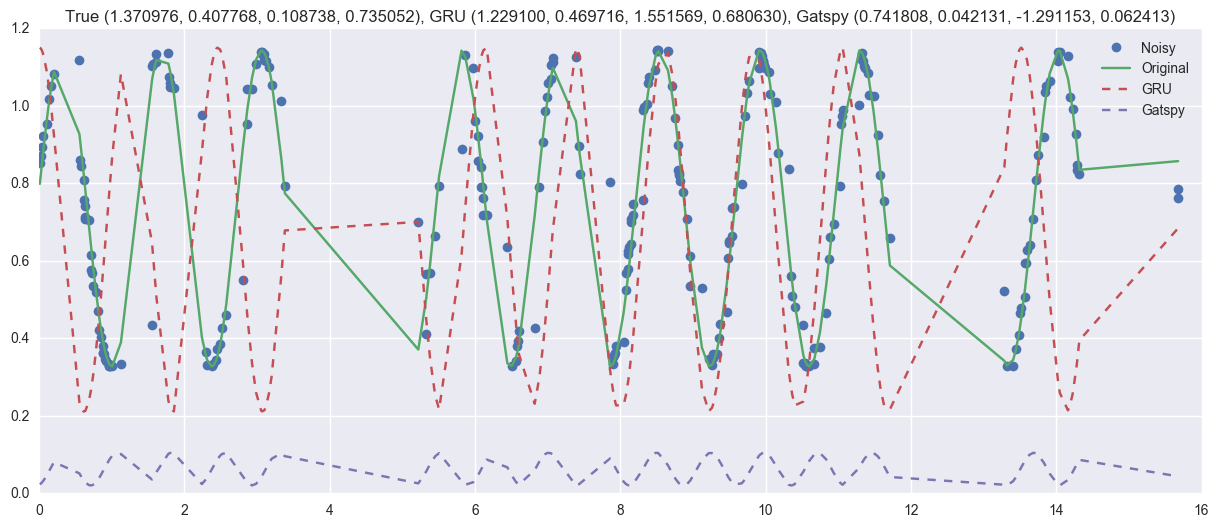

In [13]:
i += 1
if args.even:
    t = np.linspace(0, 2 * np.pi, args.n_max)
    x = X[test[i]].ravel()
else:
    t = X[test[i], :, 0].cumsum()
    x = X[test[i], :, 1]
plt.plot(t, x, 'o')

p, A, phi, b = Y[test[i]]
plt.plot(t, A * np.sin(2 * np.pi / p * t + phi) + b, '-')

#p_c, A_c, phi_c, b_c = pred_conv[i]
#x_c = A_c * np.sin(2 * np.pi / p_c * t + phi_c) + b_c
#plt.plot(t, x_c, '--')

p_r, A_r, phi_r, b_r = pred_gru[i]
x_r = A_r * np.sin(2 * np.pi / p_r * t + phi_r) + b_r
plt.plot(t, x_r, '--')

#omega = 2 * np.pi / model_gat.best_period
#off, A1, A2 = model_gat._best_params(omega)
#w_g, A_g, phi_g, b_g = [omega / 2 / np.pi, np.sqrt(A1 ** 2 + A2 ** 2), np.arctan2(A2, A1), off + model_gat.ymean_]
p_g, A_g, phi_g, b_g = pred_gat[i]
x_g = A_g * np.sin(2 * np.pi / p_g * t + phi_g) + b_g
#x_g = model_gat.fit(t, x).predict(t)
plt.plot(t, x_g, '--')

#plt.legend(['Noisy', 'Original', 'Convolutional', 'GRU', 'Gatspy'])
#plt.title("True ({:3f}, {:3f}, {:3f}, {:3f}), Conv ({:3f}, {:3f}, {:3f}, {:3f}), GRU ({:3f}, {:3f}, {:3f}, {:3f}), Gatspy ({:3f}, {:3f}, {:3f}, {:3f})".format(
#    p, A, phi, b,
#    p_c, A_c, phi_c, b_c,
#    p_r, A_r, phi_r, b_r,
#    p_g, A_g, phi_g, b_g,
#    ))
plt.legend(['Noisy', 'Original', 'GRU', 'Gatspy'])
plt.title("True ({:3f}, {:3f}, {:3f}, {:3f}), GRU ({:3f}, {:3f}, {:3f}, {:3f}), Gatspy ({:3f}, {:3f}, {:3f}, {:3f})".format(
    p, A, phi, b,
    p_r, A_r, phi_r, b_r,
    p_g, A_g, phi_g, b_g,
    ));

In [ ]:
i = 13
p, A, phi, b = Y[test[i]]
if args.even:
    t = np.linspace(0, 2 * np.pi, args.n_max)
    x = X[test[i]].ravel()
else:
    t = X[i, :, 0]
#    x = X[i, :, 1]
    x = A * np.sin(2 * np.pi / p * t + phi) + b + np.random.normal(size=len(t), loc=0, scale=1)
plt.plot(t, x, 'o')

plt.plot(t, A * np.sin(2 * np.pi / p * t + phi) + b, 'o')

plt.legend(['Noisy', 'Original'])
plt.title("Period={:3f}, amplitude={:3f}, phase={:3f}, offset={:3f}".format(p, A, phi - np.pi, b))
plt.xlim([0, 2 * np.pi])
plt.hlines([b], 0, 2 * np.pi, linestyles='dotted')
#plt.vlines([phi], -3, 6, linestyles='dotted')
if args.even:
    plt.savefig("periodic_even.png")
else:
    plt.savefig("periodic_uneven.png")

In [ ]:
sns.jointplot(pred_gru[:, 0] - Y[test, 0], pred_gat[:, 0] - Y[test, 0], kind='hex')
plt.title("GRU MSE: {}\nGatspy MSE: {}".format(np.mean((pred_gru[:, 0] - Y[test, 0]) ** 2), np.mean((pred_gat[:, 0] - Y[test, 0]) ** 2)))
#plt.title("GRU MAE: {}\nGatspy MAE: {}".format(np.median(np.abs(pred_gru[:, 0] - Y[test, 0])), np.median(np.abs(pred_gat[:, 0] - Y[test, 0]))))
sns.jointplot(pred_gru[:, 0], Y[test, 0], kind='hex')
sns.jointplot(pred_gat[:, 0], Y[test, 0], kind='hex')